In [1]:
#!nvidia-smi

# Diabetes Dataset Description

## Overview
Diabetes is among the most prevalent chronic diseases in the United States, impacting millions of Americans each year and exerting a significant financial burden on the economy. Diabetes is a serious chronic disease in which individuals lose the ability to effectively regulate levels of glucose in the blood, and can lead to reduced quality of life and life expectancy. After different foods are broken down into sugars during digestion, the sugars are then released into the bloodstream. This signals the pancreas to release insulin. Insulin helps enable cells within the body to use those sugars in the bloodstream for energy. Diabetes is generally characterized by either the body not making enough insulin or being unable to use the insulin that is made as effectively as needed.
This notebook provides a brief overview of the diabetes dataset sourced from the "diabetes_012_health_indicators_BRFSS2015.csv" file. The dataset encompasses various health indicators related to diabetes and associated factors. The columns in the dataset are as follows:
| Column                   | Description                                            |
|--------------------------|--------------------------------------------------------|
| Diabetes_binary          | Indicator for the presence of diabetes (No Diabetes, Diabetic).|
| HighBP                   | Binary indicator for blood pressure (Normal BP, High BP).     |
| HighChol                 | Binary indicator for cholesterol levels (Normal Cholesterol, High Cholesterol).        |
| CholCheck                | Binary indicator for cholesterol check (Not Checked, Checked).       |
| BMI                      | Body Mass Index (numeric).                              |
| Smoker                   | Binary indicator for smoking status (Non-Smoker, Smoker).           |
| Stroke                   | Binary indicator for history of stroke (No Stroke, Stroke).       |
| HeartDiseaseorAttack     | Binary indicator for history of heart disease or heart attack (No Heart Disease/Attack, Heart Disease/Attack). |
| PhysActivity             | Binary indicator for physical activity (Inactive, Active).       |
| Fruits                   | Numeric indicator for daily fruit consumption (No Fruits/Day, 1 or More Fruits/Day).         |
| Veggies                  | Numeric indicator for daily vegetable consumption (No Veggies/Day, 1 or More Veggies/Day).|
| HvyAlcoholConsump        | Binary indicator for heavy alcohol consumption (No Alcohol, Alcoholic).|
| AnyHealthcare            | Binary indicator for access to any healthcare (No Healthcare, Have Healthcare). |
| NoDocbcCost              | Binary indicator for no doctor visit due to cost (Cost is not an Issue, No Visit Due to Cost).    |
| GenHlth                  | Numeric indicator for general health status (Excellent, Very Good, Good, Fair, Poor).            |
| MentHlth                 | Numeric indicator for mental health status.             |
| PhysHlth                 | Numeric indicator for physical health status.           |
| DiffWalk                 | Binary indicator for difficulty in walking (No Difficulty, Yes have Difficulty).    |
| Sex                      | Binary indicator for gender (Female, Male).|
| Age                      | Numeric indicator for age (18-24 Years, 25-29 Years, ..., 80 Years or older).                             |
| Education                | Numeric indicator for education level (Never attended school..., College 4 years or more).                  |
| Income                   | Numeric indicator for income level (less than $10,000, ..., $75,000 or more).                     |


In [2]:
import warnings
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from cuml.ensemble import RandomForestClassifier as cumlRandomForestClassifier
from cuml.svm import SVC as cumlSVC
from cuml.neighbors import KNeighborsClassifier as cumlKNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# Ignore all future and user warnings 
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [4]:
# Reading dataset csv into pandas df
df = pd.read_csv("data/diabetes_binary_health_indicators_BRFSS2015.csv")
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [5]:
# Defining a class for EDA of dataset
class EDA:
    def __init__(self, dataset):
        self.df = dataset

    def display_info(self):
        # Display basic information about the dataset
        info_df = pd.DataFrame({
            'Data Type': self.df.dtypes,
            'Unique Values': self.df.nunique()
        })
        return info_df

    def display_summary_statistics(self):
        # Display summary statistics of numerical columns
        summary_stats = self.df.describe().transpose()
        return summary_stats

    def display_missing_values(self):
        # Display missing values in the dataset
        missing_values_df = pd.DataFrame({
            'Missing Values': self.df.isnull().sum(),
            'Percentage Missing': (self.df.isnull().sum() / len(self.df)) * 100
        })
        return missing_values_df

    def plot_distribution(self):
        # Plot histograms for all numerical columns in subplots
        numerical_columns = self.df.select_dtypes(include=['int64', 'float64']).columns
        n_cols = 5
        n_rows = int(np.ceil(len(numerical_columns) / n_cols))
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 15))

        # Flatten the axes to a 1D array
        axes = axes.flatten()

        # Loop over the subplots and plot the histograms
        for ax, col in zip(axes, numerical_columns):
            sns.histplot(data=self.df, x=col, ax=ax, bins=20, kde=True, color='green') 
            ax.set_title(col, fontsize=14)

        # Remove the empty subplots
        for ax in axes[len(numerical_columns):]:
            ax.remove()

        # Adjust the spacing between subplots
        plt.tight_layout()

        plt.show()
    
    def identify_outliers(self):
        # Calculate Z-scores
        z_scores_df = pd.DataFrame(zscore(self.df), columns=self.df.columns)

        # Identify potential outliers based on Z-scores
        potential_outliers = (z_scores_df > 3) | (z_scores_df < -3)

        # Create a summary DataFrame
        summary_stats = pd.DataFrame({
            'Mean': z_scores_df.mean(),
            'Max': z_scores_df.max(),
            'Min': z_scores_df.min(),
            'Potential Outliers': potential_outliers.any()
        })

        return summary_stats
    
    def visualize_outliers(self):
        # Identify outliers using the 'identify_outliers' method
        outliers_summary = self.identify_outliers()

        # Filter columns with potential outliers
        columns_with_outliers = outliers_summary[outliers_summary['Potential Outliers']].index

        # Set the figure size dynamically based on the number of filtered columns
        num_filtered_columns = len(columns_with_outliers)
        n_cols = 3
        n_rows = math.ceil(num_filtered_columns / n_cols)
        plt.figure(figsize=(15, 5 * n_rows))

        # Loop over columns with potential outliers and create box plots
        for i, col in enumerate(columns_with_outliers):
            plt.subplot(n_rows, n_cols, i + 1)
            sns.boxplot(x=self.df[col], palette='Set2')
            plt.title(f'Outliers in {col}', fontsize=14)
            plt.xlabel(col, fontsize=12)

        # Adjust the layout
        plt.tight_layout()
        plt.show()

    def plot_correlation_heatmap(self):
        # Set the figure size
        plt.figure(figsize=(14, 10))
        
        # Create a heatmap with a different color map
        ax = plt.axes()
        sns.heatmap(self.df.corr(), cmap='YlGnBu', annot=True, fmt='.2f')

        # Set title and adjust padding
        ax.set_title('Correlation Heatmap Between Features in the Dataset', fontsize=14, pad=10)

        # Show the plot
        plt.show()
        
    def visualize_correlation_thresholds(self, positive_threshold=0.25, negative_threshold=-0.25):
        correlation_matrix = self.df.corr()

        # Create subplots for positive and negative correlations
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

        # Plot highly positive correlations
        sns.heatmap(correlation_matrix[correlation_matrix > positive_threshold], annot=True, cmap="YlGnBu", fmt=".2f", ax=ax1)
        ax1.set_title("Highly Positive Correlations")

        # Plot highly negative correlations
        sns.heatmap(correlation_matrix[correlation_matrix < negative_threshold], annot=True, cmap="YlGnBu", fmt=".2f", ax=ax2)
        ax2.set_title("Highly Negative Correlations")

        plt.tight_layout()
        plt.show()
    
    def visualize_correlation_with_target(self, target_column):
        # Calculate correlation coefficients
        correlation_matrix = self.df.corr()
        correlation_with_target = correlation_matrix[target_column].sort_values(ascending=False)
        
        # Define a palette similar to 'YlGnBu'
        palette = ['lightgreen', 'mediumseagreen', 'forestgreen', 'darkgreen']

        # Visualize correlations using a bar chart
        plt.figure(figsize=(12, 8))
        sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, orient='h', palette=palette)
        plt.title(f"Correlation with {target_column}")
        plt.show()
    
    def plot_target_distribution(self, target_variable):
        # Plotting value counts of the target variable by using countplot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

        # Custom color palette for the countplot
        countplot_palette = ['lightgreen', 'lightcoral']

        sns.countplot(data=self.df, x=target_variable, ax=ax1, palette=countplot_palette)
        ax1.set_title(f"{target_variable} Distribution")

        # Annotate each bar with the count
        for p in ax1.patches:
            ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        # Custom colors for the pie chart
        pie_chart_colors = ['lightgreen', 'lightcoral']

        labels = self.df[target_variable].value_counts().index
        sizes = self.df[target_variable].value_counts()
        ax2.pie(sizes, labels=labels, autopct='%.02f%%', colors=pie_chart_colors)
        ax2.set_title(f"{target_variable} Proportion")

        # Adjust spacing and layout
        fig.subplots_adjust(wspace=0.5, right=0.8)

        plt.show()

In [6]:
# Initializing object from class EDA
eda = EDA(df)

In [7]:
# Info of dataset
eda.display_info()

,Data Type,Unique Values
Diabetes_binary,float64,2
HighBP,float64,2
HighChol,float64,2
CholCheck,float64,2
BMI,float64,84
Smoker,float64,2
Stroke,float64,2
HeartDiseaseorAttack,float64,2
PhysActivity,float64,2
Fruits,float64,2


In [8]:
# Summary of dataset
eda.display_summary_statistics()

,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,253680.0,0.139333,0.346294,0.0,0.0,0.0,0.0,1.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


In [9]:
# Missing values in the dataset
eda.display_missing_values()

,Missing Values,Percentage Missing
Diabetes_binary,0,0.0
HighBP,0,0.0
HighChol,0,0.0
CholCheck,0,0.0
BMI,0,0.0
Smoker,0,0.0
Stroke,0,0.0
HeartDiseaseorAttack,0,0.0
PhysActivity,0,0.0
Fruits,0,0.0


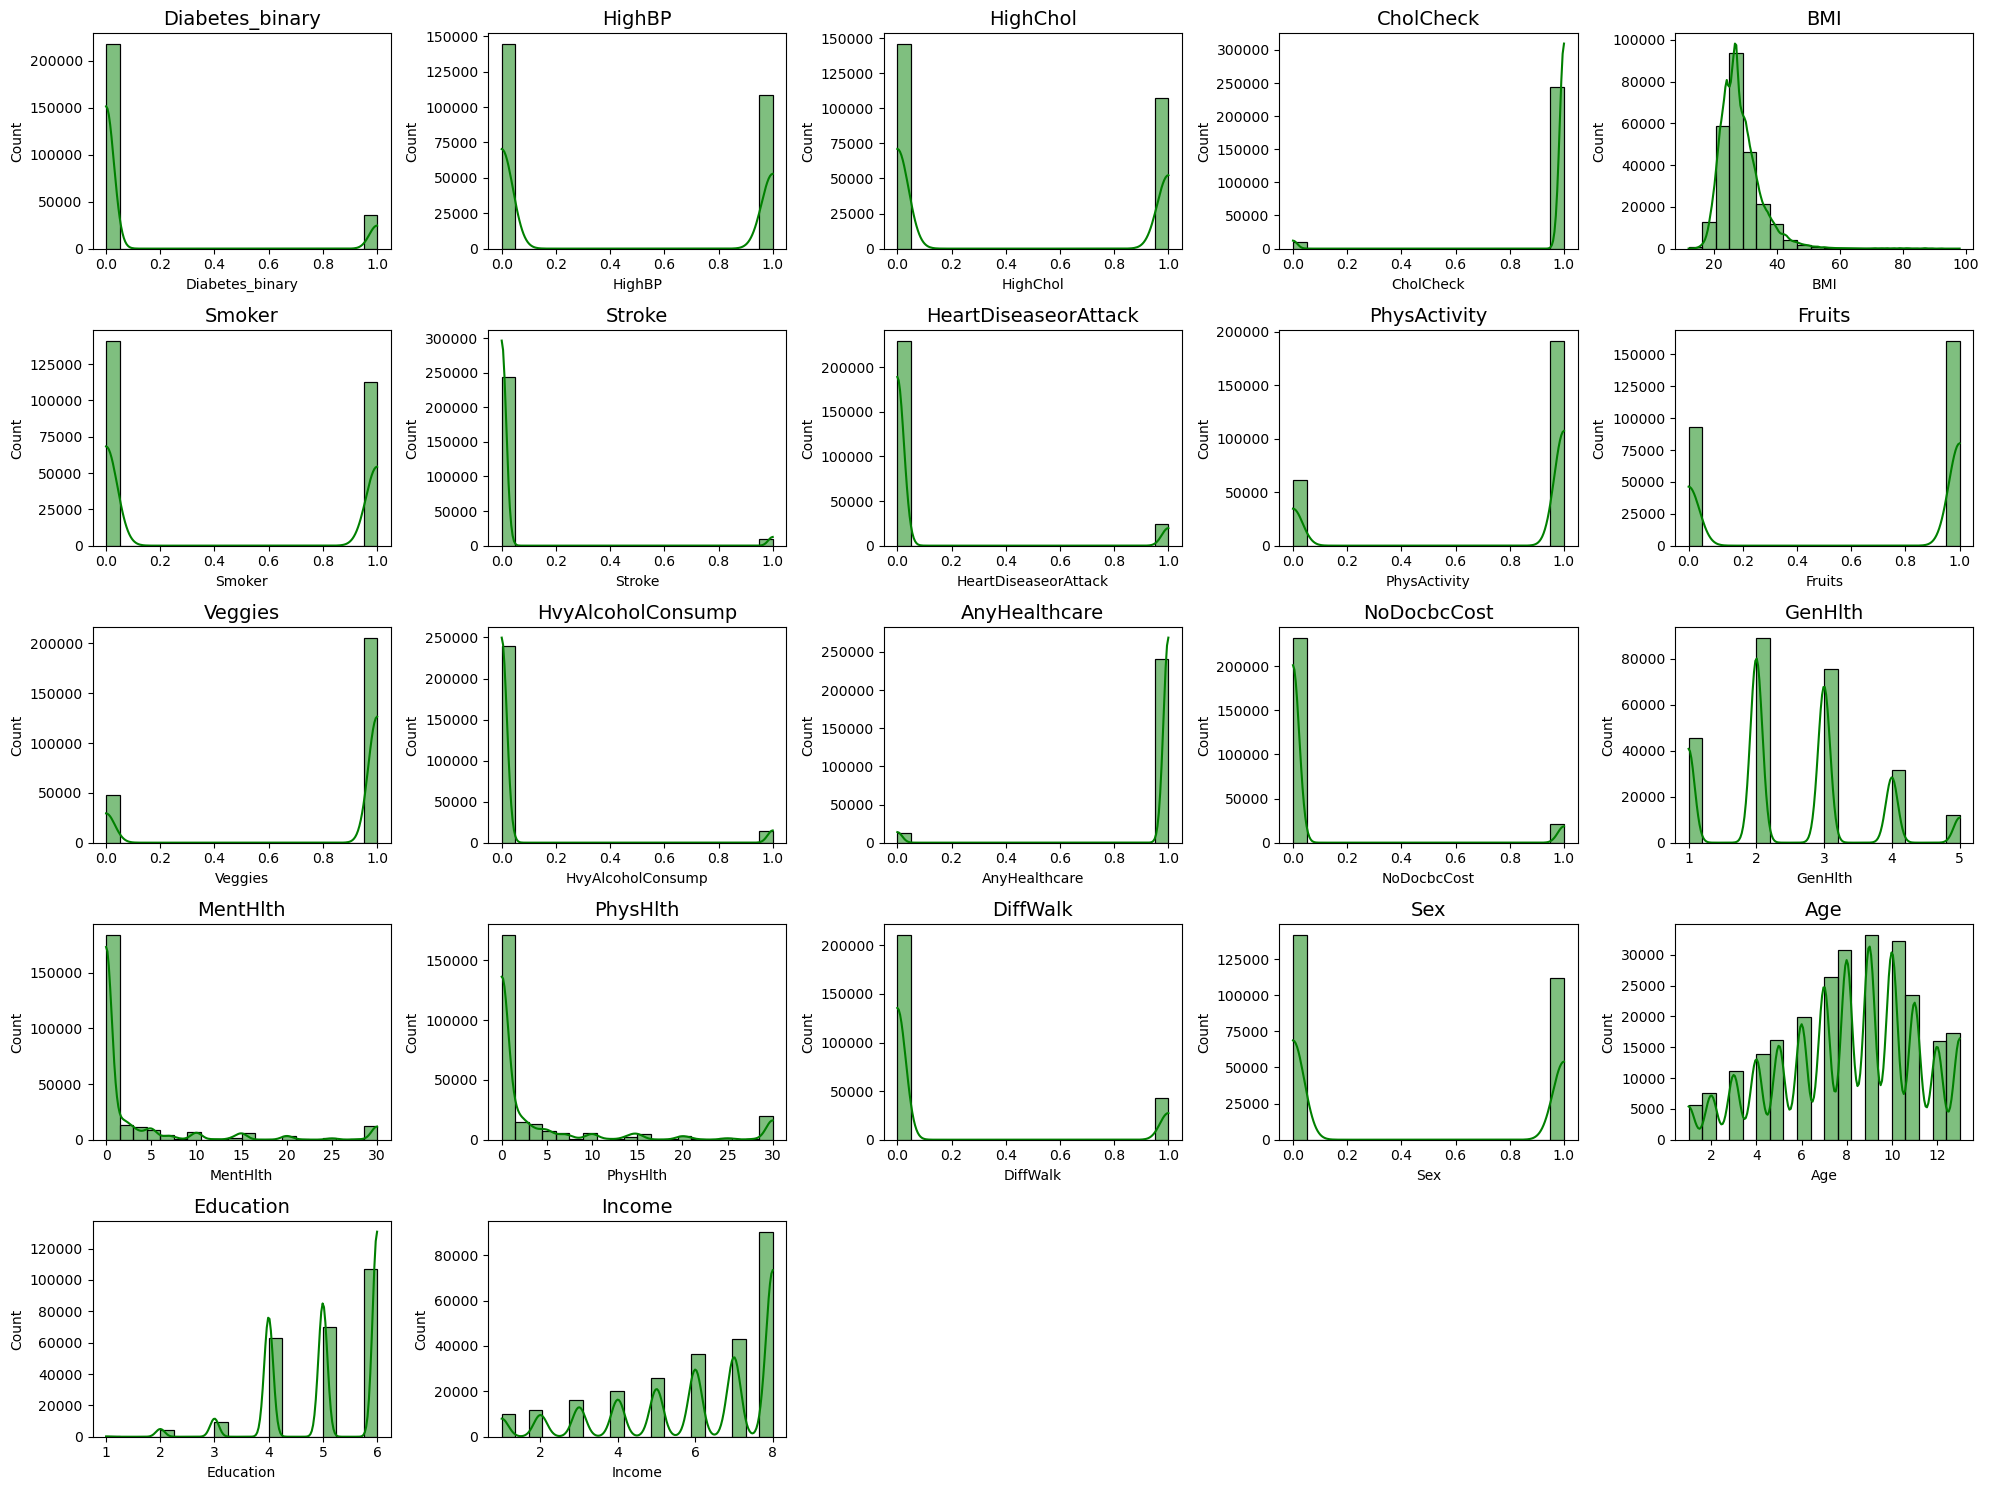

In [10]:
# Plotting the distribution of all numerical columns of dataset
eda.plot_distribution()

In [11]:
# Identifying outliers using z-score
eda.identify_outliers()

,Mean,Max,Min,Potential Outliers
Diabetes_binary,-6.453368e-17,2.485367,-0.402355,False
HighBP,-1.250340e-16,1.153688,-0.866785,False
HighChol,5.769939e-17,1.165254,-0.858182,False
CholCheck,1.245859e-16,0.196922,-5.078164,True
BMI,-2.505162e-16,10.534271,-2.478916,True
Smoker,2.688903e-17,1.120927,-0.892119,False
Stroke,-4.033355e-18,4.862949,-0.205637,True
HeartDiseaseorAttack,4.257430e-18,3.101183,-0.322458,True
PhysActivity,5.377807e-17,0.567275,-1.762814,False
Fruits,5.601882e-17,0.759375,-1.316872,False


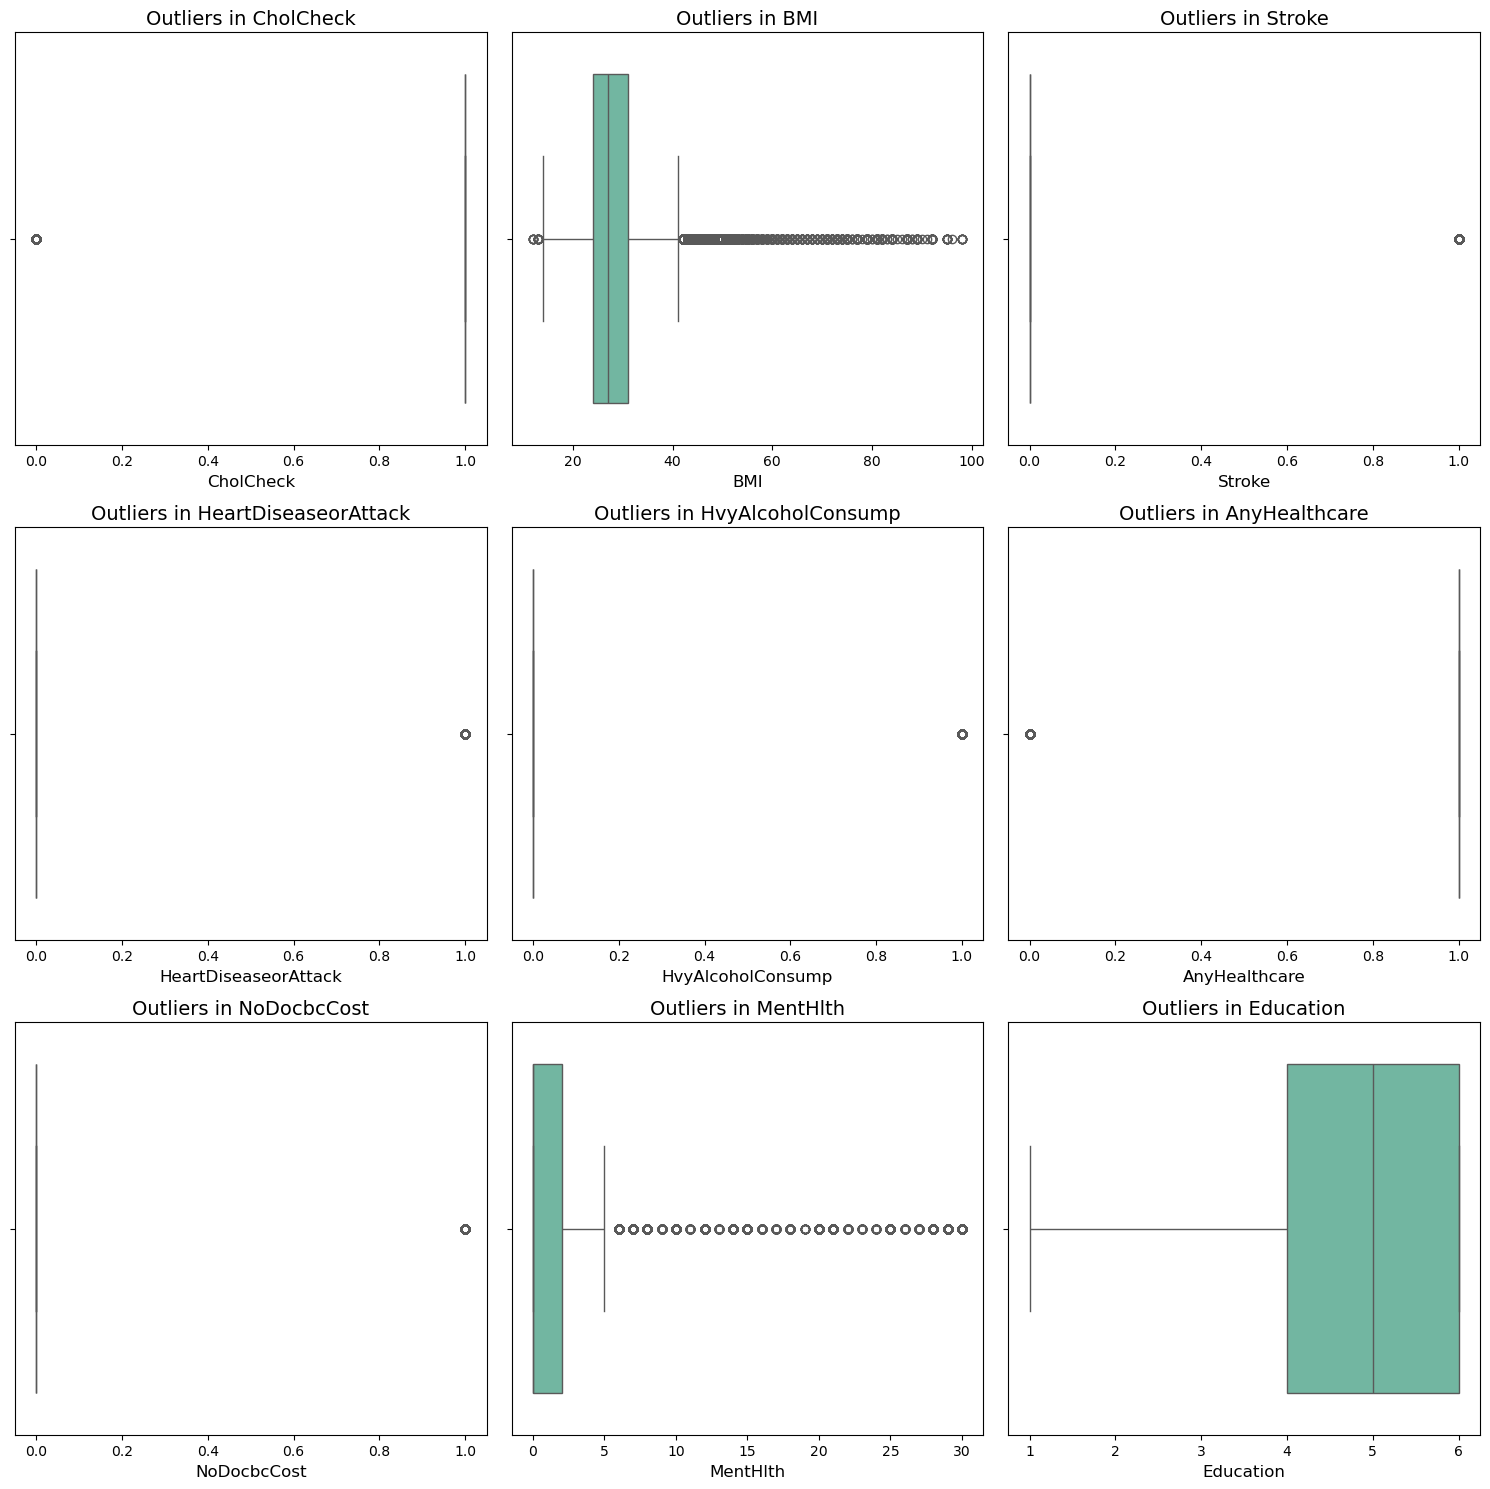

In [12]:
# Visualizing outliers using box plot
eda.visualize_outliers()

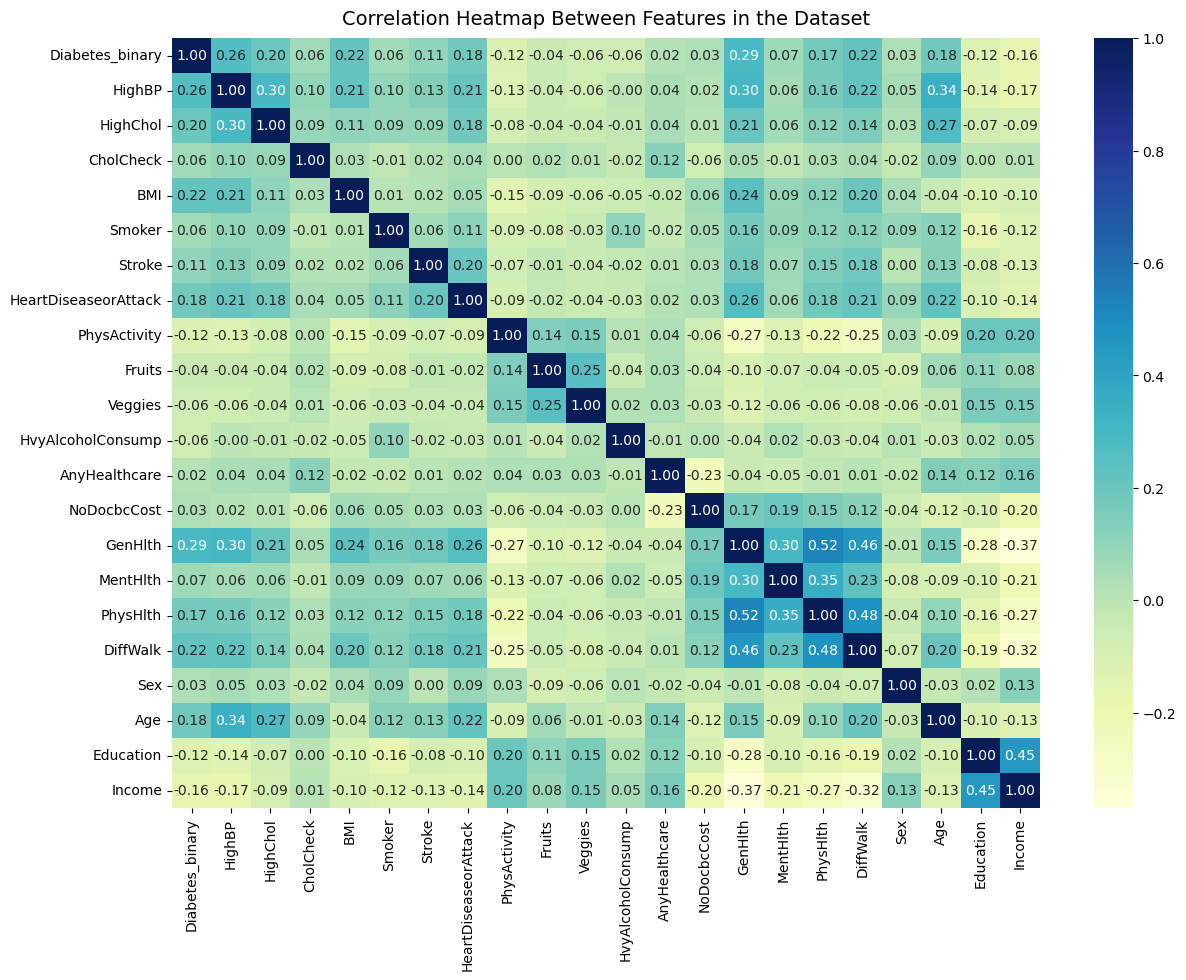

In [13]:
eda.plot_correlation_heatmap()

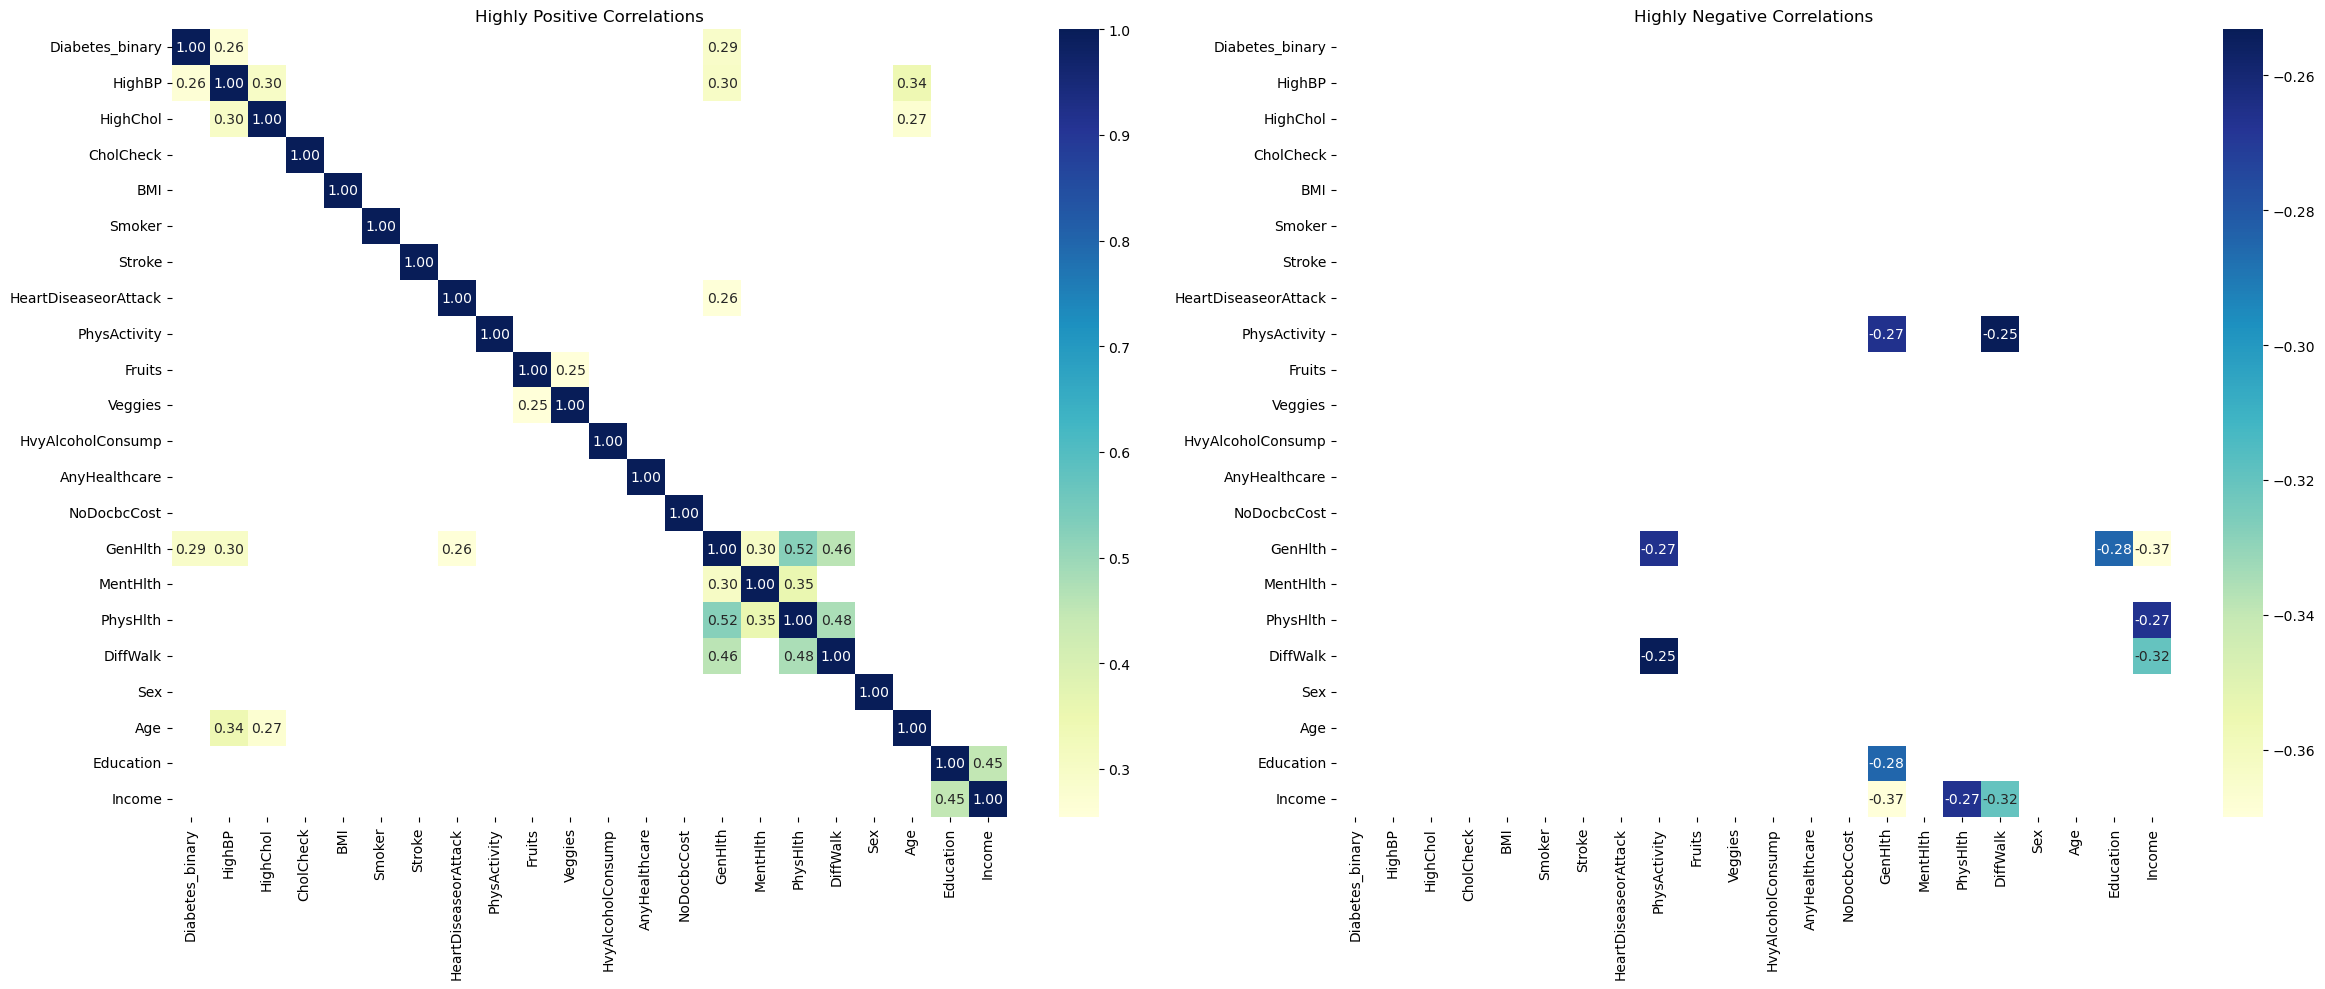

In [14]:
eda.visualize_correlation_thresholds()

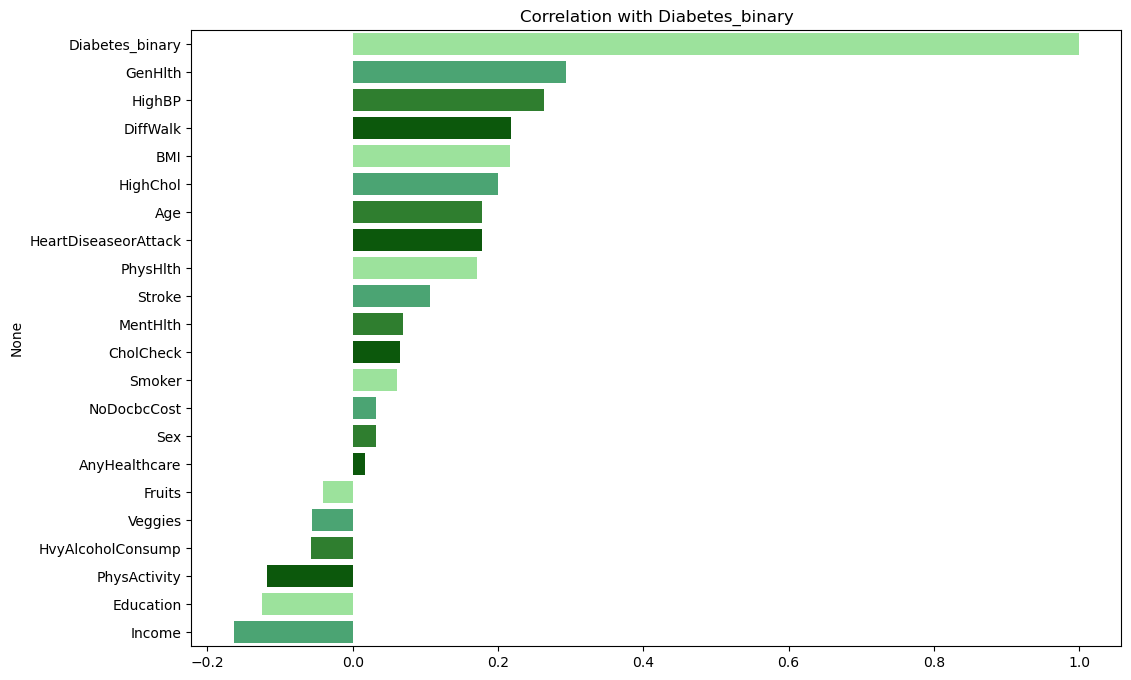

In [15]:
eda.visualize_correlation_with_target('Diabetes_binary')

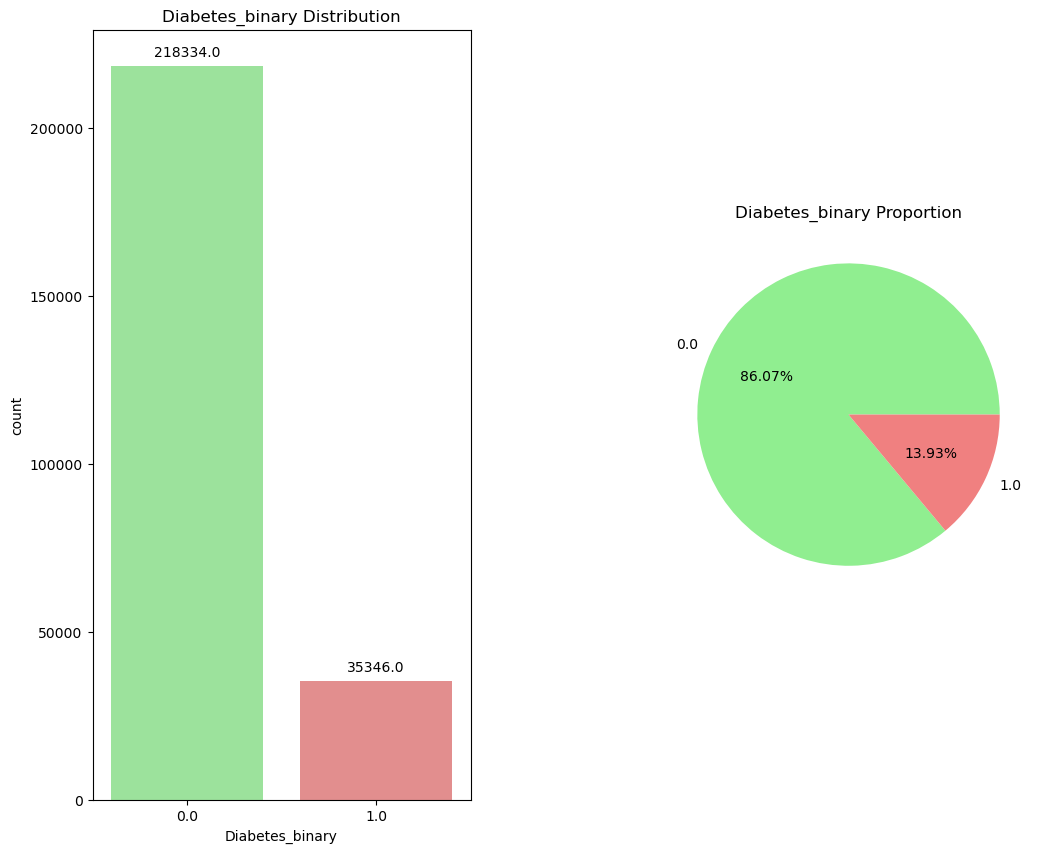

In [16]:
eda.plot_target_distribution('Diabetes_binary')

In [17]:
# Drop columns
df.drop(["CholCheck", "Smoker", "AnyHealthcare", "NoDocbcCost", "Education", "Income"], axis=1, inplace=True)
df.head()

,Diabetes_binary,HighBP,HighChol,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,1.0,40.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0
1,0.0,0.0,0.0,25.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0
2,0.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0
3,0.0,1.0,0.0,27.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0
4,0.0,1.0,1.0,24.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0


In [18]:
# Defining a class for data preprocessing
class DataPreprocessor:
    def __init__(self, numerical_columns, categorical_columns, target_column):
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.target_column = target_column
        self.scalers = {} 

    def fit_transform(self, df):
        # Handle missing values
        df = self.handle_missing_values(df)

        # One-hot encode categorical variables
        df = self.one_hot_encode_categorical(df)

        # Scale numerical features
        df = self.scale_numerical_features(df)

        return df

    def handle_missing_values(self, df):
        # Impute missing numerical values with the mean
        df[self.numerical_columns] = df[self.numerical_columns].fillna(df[self.numerical_columns].mean())

        # Impute missing categorical values with the most frequent value (mode)
        df[self.categorical_columns] = df[self.categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))

        return df
    
    def one_hot_encode_categorical(self, df):
        # One-hot encode categorical variables
        df = pd.get_dummies(df, columns=self.categorical_columns, drop_first=True)
        return df

    def scale_numerical_features(self, df):
        for col in self.numerical_columns:
            if col != self.target_column:
                unique_values = df[col].nunique()

                if unique_values <= 10:
                    # Use MinMaxScaler for columns with fewer unique values
                    scaler = MinMaxScaler()
                else:
                    # Use StandardScaler for columns with more unique values
                    scaler = StandardScaler()

                # Store the scaler for later use
                self.scalers[col] = scaler

                # Apply the scaler to the column
                df[col] = scaler.fit_transform(df[[col]])

        return df

In [19]:
# Data preprocessing
target_column = 'Diabetes_binary'
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Instantiate the DataPreprocessor
preprocessor = DataPreprocessor(numerical_columns, categorical_columns, target_column)

# Fit and transform the dataset
df_preprocessed = preprocessor.fit_transform(df) 
df_preprocessed.head()

,Diabetes_binary,HighBP,HighChol,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,1.0,1.757936,0.0,0.0,0.0,0.0,1.0,0.0,1.00,1.998592,1.233999,1.0,0.0,0.316900
1,0.0,0.0,0.0,-0.511806,0.0,0.0,1.0,0.0,0.0,0.0,0.50,-0.429630,-0.486592,0.0,0.0,-0.337933
2,0.0,1.0,1.0,-0.057858,0.0,0.0,0.0,1.0,0.0,0.0,1.00,3.617407,2.954590,1.0,0.0,0.316900
3,0.0,1.0,0.0,-0.209174,0.0,0.0,1.0,1.0,1.0,0.0,0.25,-0.429630,-0.486592,0.0,0.0,0.971733
4,0.0,1.0,1.0,-0.663122,0.0,0.0,1.0,1.0,1.0,0.0,0.25,-0.024926,-0.486592,0.0,0.0,0.971733


In [20]:
# Defining a class for model evaluation
class ModelEvaluator:
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def evaluate(self):
        y_pred = self.model.predict(self.X_test)
       
        # Accuracy
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"Accuracy: {accuracy:.2f}")

        # Classification Report
        print("Classification Report:\n", classification_report(self.y_test, y_pred))
        
        # Confusion Matrix
        self.plot_confusion_matrix(self.y_test, y_pred)

In [21]:
# Setting target and features from preprocessed dataset
X = df_preprocessed.drop(columns=['Diabetes_binary'])
y = df_preprocessed['Diabetes_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (202944, 15)
X_test shape: (50736, 15)
y_train shape: (202944,)
y_test shape: (50736,)


Random Forest Model Evaluation:

Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.95      0.92     43739
         1.0       0.43      0.21      0.28      6997

    accuracy                           0.85     50736
   macro avg       0.66      0.58      0.60     50736
weighted avg       0.82      0.85      0.83     50736



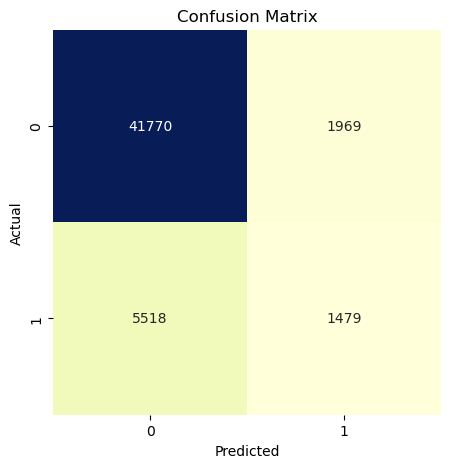

Runtime: 9.8487 seconds

Gradient Boosting Model Evaluation:

Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     43739
         1.0       0.57      0.17      0.26      6997

    accuracy                           0.87     50736
   macro avg       0.73      0.57      0.59     50736
weighted avg       0.84      0.87      0.84     50736



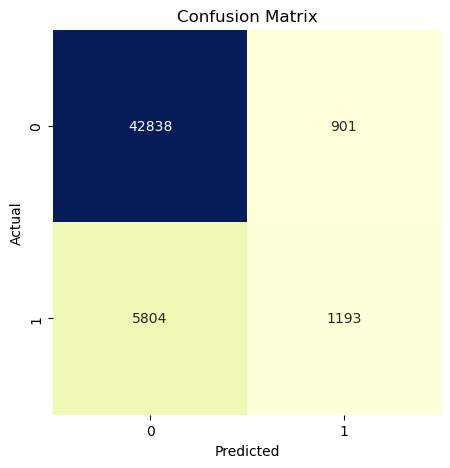

Runtime: 9.0068 seconds

XGBoost Model Evaluation:

Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     43739
         1.0       0.56      0.17      0.26      6997

    accuracy                           0.87     50736
   macro avg       0.72      0.57      0.59     50736
weighted avg       0.84      0.87      0.83     50736



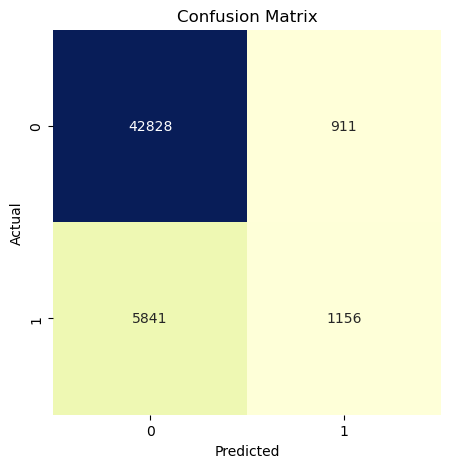

Runtime: 2.4221 seconds

CatBoost Model Evaluation:

Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     43739
         1.0       0.58      0.16      0.25      6997

    accuracy                           0.87     50736
   macro avg       0.73      0.57      0.59     50736
weighted avg       0.84      0.87      0.83     50736



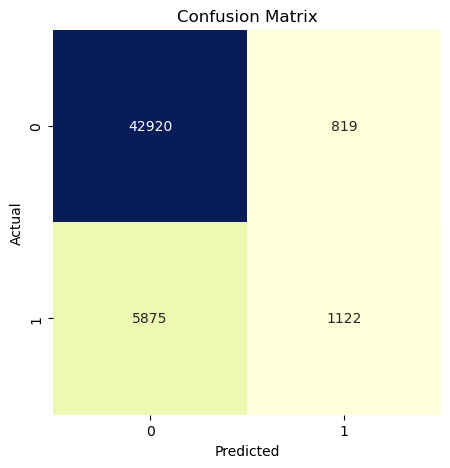

Runtime: 10.8511 seconds



In [22]:
# Create classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, task_type='GPU')
}
# Dictionary to store runtime information
sklearn_runtimes = {}

# Train and evaluate each scikit-learn model
for name, model in classifiers.items():
    start_time = time.time()
    pipeline = make_pipeline(model)
    pipeline.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    sklearn_runtimes[name] = elapsed_time
    print(f"{name} Model Evaluation:\n")
    model_evaluator = ModelEvaluator(pipeline, X_test, y_test)
    model_evaluator.evaluate()
    print(f"Runtime: {elapsed_time:.4f} seconds\n")

Random Forest Model Evaluation:

Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.99      0.93     43739
         1.0       0.57      0.12      0.20      6997

    accuracy                           0.87     50736
   macro avg       0.72      0.55      0.56     50736
weighted avg       0.83      0.87      0.83     50736



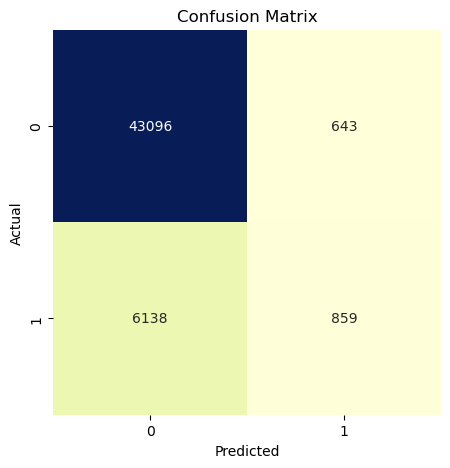

Runtime: 1.5245 seconds

Support Vector Machine Model Evaluation:

Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.99      0.93     43739
         1.0       0.63      0.07      0.13      6997

    accuracy                           0.87     50736
   macro avg       0.75      0.53      0.53     50736
weighted avg       0.84      0.87      0.82     50736



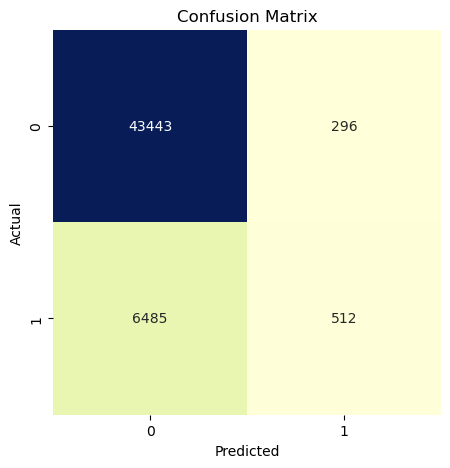

Runtime: 124.7896 seconds

K-Nearest Neighbors Model Evaluation:

Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.95      0.92     43739
         1.0       0.41      0.22      0.29      6997

    accuracy                           0.85     50736
   macro avg       0.65      0.59      0.60     50736
weighted avg       0.82      0.85      0.83     50736



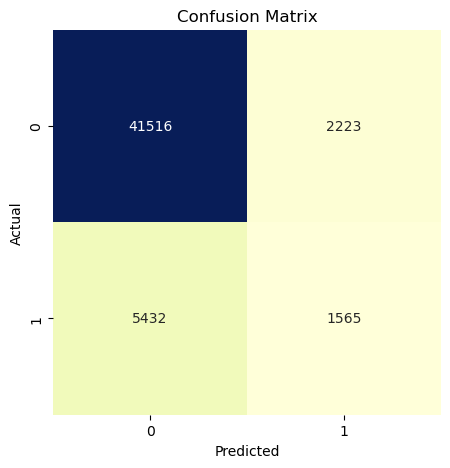

Runtime: 0.0286 seconds



In [23]:
# Create classifiers
classifiers_cuml = {
    'Random Forest': cumlRandomForestClassifier(random_state=42),
    'Support Vector Machine': cumlSVC(),
    'K-Nearest Neighbors': cumlKNeighborsClassifier()
    
}
# Dictionary to store runtime information
cuml_runtimes = {}

# Train and evaluate each scikit-learn model
for name, model in classifiers_cuml.items():
    start_time = time.time()
    pipeline = make_pipeline(model)
    pipeline.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    cuml_runtimes[name] = elapsed_time
    print(f"{name} Model Evaluation:\n")
    model_evaluator = ModelEvaluator(pipeline, X_test, y_test)
    model_evaluator.evaluate()
    print(f"Runtime: {elapsed_time:.4f} seconds\n")

Random Forest Model Evaluation:

Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.92      0.90     43739
         1.0       0.34      0.25      0.29      6997

    accuracy                           0.83     50736
   macro avg       0.61      0.59      0.60     50736
weighted avg       0.81      0.83      0.82     50736



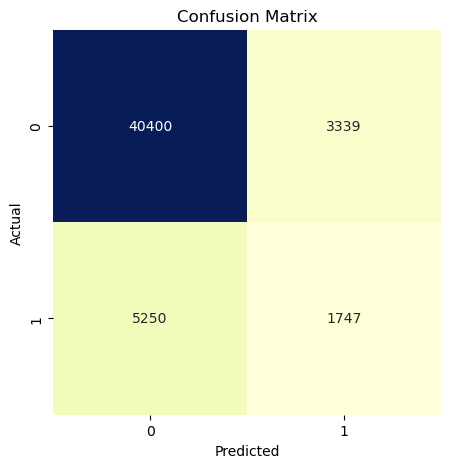

Runtime: 9.9847 seconds

CatBoost Model Evaluation:

Accuracy: 0.72
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.71      0.81     43739
         1.0       0.31      0.80      0.44      6997

    accuracy                           0.72     50736
   macro avg       0.63      0.76      0.63     50736
weighted avg       0.87      0.72      0.76     50736



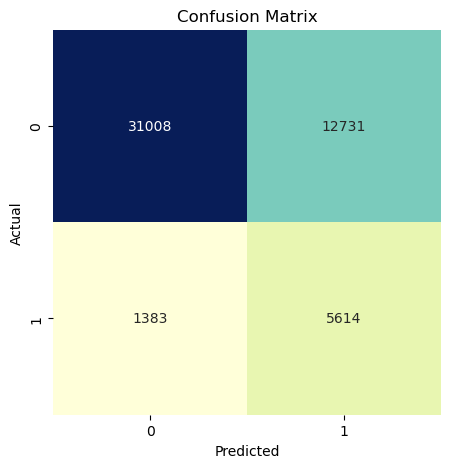

Runtime: 9.3576 seconds



In [24]:
# Classification with class weights
class_weights = {0: 1 / 0.8607, 1: 1 / 0.1393}
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight=class_weights),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, class_weights=class_weights, task_type='GPU')
}
# Dictionary to store runtime information
sklearn_runtimes = {}

# Train and evaluate each scikit-learn model
for name, model in classifiers.items():
    start_time = time.time()
    pipeline = make_pipeline(model)
    pipeline.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    sklearn_runtimes[name] = elapsed_time
    print(f"{name} Model Evaluation:\n")
    model_evaluator = ModelEvaluator(pipeline, X_test, y_test)
    model_evaluator.evaluate()
    print(f"Runtime: {elapsed_time:.4f} seconds\n")

Random Forest Model Evaluation:

Accuracy: 0.70
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.69      0.80     43739
         1.0       0.28      0.76      0.41      6997

    accuracy                           0.70     50736
   macro avg       0.61      0.72      0.60     50736
weighted avg       0.86      0.70      0.74     50736



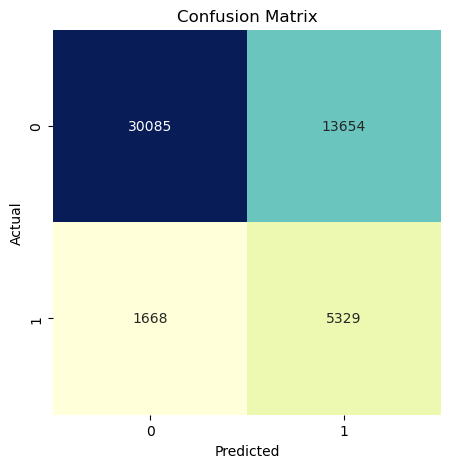

Runtime: 2.7708 seconds

CatBoost Model Evaluation:

Accuracy: 0.72
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.71      0.81     43739
         1.0       0.30      0.80      0.44      6997

    accuracy                           0.72     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.87      0.72      0.76     50736



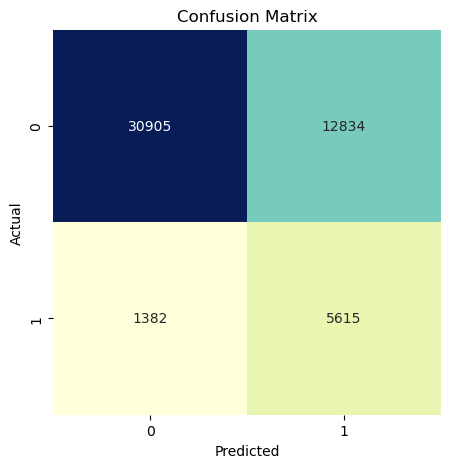

Runtime: 9.7866 seconds



In [25]:
# Instantiate RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Fit and transform the training data
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, task_type='GPU')
}
# Dictionary to store runtime information
sklearn_runtimes = {}

# Train and evaluate each scikit-learn model
for name, model in classifiers.items():
    start_time = time.time()
    pipeline = make_pipeline(model)
    pipeline.fit(X_train_undersampled, y_train_undersampled)
    end_time = time.time()
    elapsed_time = end_time - start_time
    sklearn_runtimes[name] = elapsed_time
    print(f"{name} Model Evaluation:\n")
    model_evaluator = ModelEvaluator(pipeline, X_test, y_test)
    model_evaluator.evaluate()
    print(f"Runtime: {elapsed_time:.4f} seconds\n")
